### Import Required Libraries


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, Bidirectional, Input, GRU
from sklearn.metrics import confusion_matrix, classification_report
from typing import List, Tuple
import random


In [2]:
# Set the seed for reproducibility
tf.random.set_seed(42)
np.random.seed(42)
random.seed(42)

### Load the dataset

In [3]:
df= pd.read_csv('./TVaritDoc.csv')

print(df.head(), "\n\n", "Shape:",df.shape)

                   timestamp           part_id  temperature_1  temperature_2  \
0  2024-02-15 05:44:34+05:30  2124077390649042          439.1          424.1   
1  2024-02-15 05:44:35+05:30  2124077390649042          438.9          423.9   
2  2024-02-15 05:44:36+05:30  2124077390649042          438.7          423.6   
3  2024-02-15 05:44:37+05:30  2124077390649042          438.4          423.4   
4  2024-02-15 05:44:38+05:30  2124077390649042          438.2          423.2   

   temperature_3  temperature_4  label  
0          536.0          518.6      0  
1          535.9          518.7      0  
2          535.6          518.9      0  
3          535.4          519.0      0  
4          535.2          519.2      0   

 Shape: (100000, 7)


In [4]:
df.columns

Index(['timestamp', 'part_id', 'temperature_1', 'temperature_2',
       'temperature_3', 'temperature_4', 'label'],
      dtype='object')

In [5]:
print("Checking for missing values", df.isnull().sum(), "\n\n")

print("Unique values in the label column: ", df.label.unique(), "\n\n")\

print("Number of different part ids: ", df.part_id.nunique(), "\n\n")

Checking for missing values timestamp        0
part_id          0
temperature_1    0
temperature_2    0
temperature_3    0
temperature_4    0
label            0
dtype: int64 


Unique values in the label column:  [0 1] 


Number of different part ids:  295 




<Axes: xlabel='timestamp'>

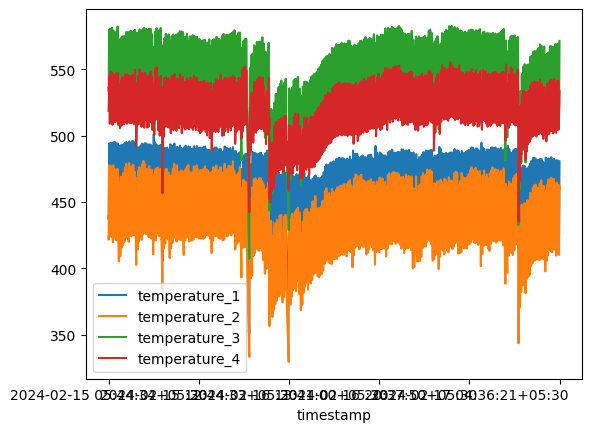

In [6]:
df.plot(x='timestamp', y=['temperature_1', 'temperature_2', 'temperature_3', 'temperature_4'])

### Prepare the dataset with required Features- Max, min, std

#### Aggregate the data by part_id column to generate features

In [7]:
grouped_df = df.groupby('part_id').agg({
    'temperature_1': ['std', 'max', 'min'],
    'temperature_2': ['std', 'max', 'min'],
    'temperature_3': ['std', 'max', 'min'],
    'temperature_4': ['std', 'max', 'min'],
    'label': 'first'  # Retain the label information, Assuming that the label is the same 
                    #for all rows of a part_id and doesnt change during the process
})

# Flatten the MultiIndex columns
grouped_df.columns = ['_'.join(col) for col in grouped_df.columns]

# Reset index if you want part_id to be a column
grouped_df = grouped_df.reset_index()
grouped_df.drop(columns=['part_id'], inplace=True)

# print(grouped_df)

### Standardize the data

In [8]:
## Standardize the data

scaler = StandardScaler()
X = grouped_df.drop(columns=['label_first'])
y = grouped_df['label_first']
X = scaler.fit_transform(X)

scaled_grouped_df = pd.DataFrame(X, columns=grouped_df.drop(columns=['label_first']).columns)
scaled_grouped_df['label'] = y.values

print(scaled_grouped_df)

     temperature_1_std  temperature_1_max  temperature_1_min  \
0            -0.161866           1.179043           0.801236   
1            -0.184328           1.221417           1.067769   
2             0.082638           1.179043           0.880209   
3             0.094792           1.306164           0.712392   
4             0.105760           1.334413           0.909824   
..                 ...                ...                ...   
290          -0.338366          -0.459408          -0.156305   
291          -0.294554          -0.643027          -0.116819   
292          -0.228090          -0.614778          -0.314250   
293          -0.261475          -0.643027          -0.166177   
294           0.606564          -0.741899          -0.304379   

     temperature_2_std  temperature_2_max  temperature_2_min  \
0            -0.123062           1.066063           0.782578   
1            -0.289959           1.066063           0.999295   
2             0.004210           0.9698

#### Various plots for the features

#### Class imbalance check

Total number of labels:  295
Number of labels with value 0:  276
Number of labels with value 1:  19


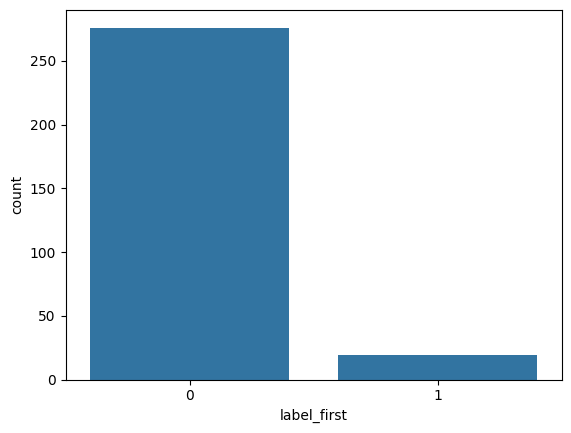

In [9]:
# Split the data into features and labels
countPlot = sns.countplot(x='label_first', data=grouped_df)
print("Total number of labels: ", grouped_df.label_first.count())
print("Number of labels with value 0: ", grouped_df.label_first.value_counts()[0])
print("Number of labels with value 1: ", grouped_df.label_first.value_counts()[1])

#### Violin Plot

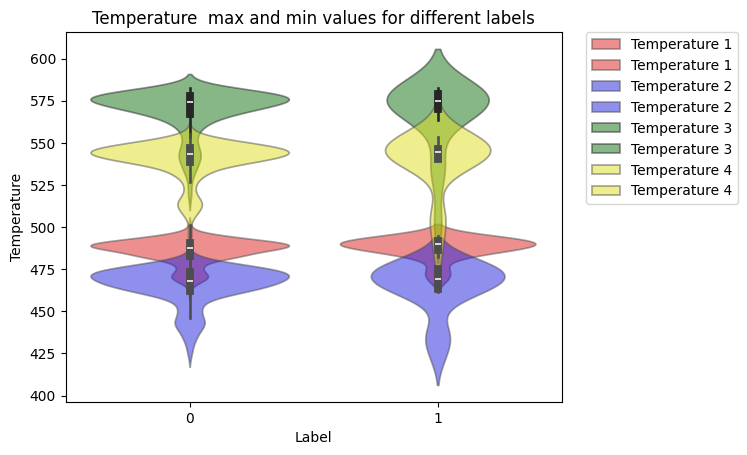

In [10]:
plot= sns.violinplot(x='label_first', y='temperature_1_max', data=grouped_df, alpha=0.5, legend=True, color='red', label='Temperature 1')

sns.violinplot(x='label_first', y='temperature_2_max', data=grouped_df, alpha=0.5, legend=True, color='blue', label='Temperature 2', ax=plot)

sns.violinplot(x='label_first', y='temperature_3_max', data=grouped_df, alpha=0.5, legend=True, color='green', label='Temperature 3', ax=plot)

sns.violinplot(x='label_first', y='temperature_4_max', data=grouped_df, alpha=0.5, legend=True, color='yellow', label='Temperature 4', ax=plot)

plot.set_title('Temperature  max and min values for different labels')
plot.set_ylabel('Temperature')
plot.set_xlabel('Label')
plot.legend(bbox_to_anchor=(1.05, 1),  borderaxespad=0.)


#### Box Plot

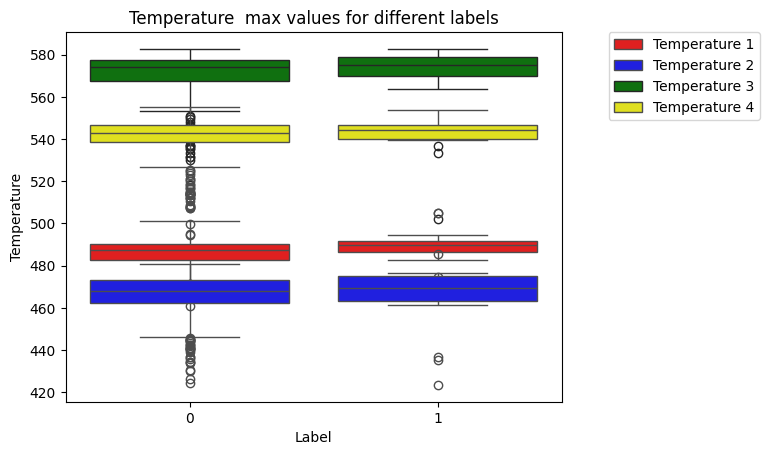

In [11]:
box_plot= sns.boxplot(x='label_first', y='temperature_1_max', data=grouped_df,  legend=True, color='red', label='Temperature 1')
sns.boxplot(x='label_first', y='temperature_2_max', data=grouped_df, legend=True, ax=box_plot, color='blue', label='Temperature 2')
sns.boxplot(x='label_first', y='temperature_3_max', data=grouped_df, legend=True, ax=box_plot, color='green', label='Temperature 3')
sns.boxplot(x='label_first', y='temperature_4_max', data=grouped_df, legend=True, ax=box_plot, color='yellow', label='Temperature 4')

box_plot.set_title('Temperature  max values for different labels')
box_plot.set_ylabel('Temperature')
box_plot.set_xlabel('Label')
box_plot.legend(loc='upper right', bbox_to_anchor=(1.4, 1), borderaxespad=0.)


### Prepare dataset for training

##### Define function to split the data into train and test

In [12]:


# Function to create windowed dataset
def create_windowed_dataset(dataset, window_size, batch_size, shuffle_buffer):
    """
    Creates a windowed dataset for time series classification.

    Args:
        dataset (pd.DataFrame): The input dataset.
        window_size (int): The size of the window.
        batch_size (int): The batch size.
        shuffle_buffer (int): The buffer size for shuffling.

    Returns:
        dataset (tf.data.Dataset): TF Dataset containing time windows.
    """
    
    
    dataset = tf.data.Dataset.from_tensor_slices(dataset)# Generate a TF Dataset from the series values
      
    
    dataset = dataset.window(window_size, shift=1, drop_remainder=True)# Window the data but only take those with the specified size
      
    dataset = dataset.flat_map(lambda window: window.batch(window_size))# Flatten the windows by putting its elements in a single batch
    dataset = dataset.map(lambda window: (window[:, :-1], window[-1, -1]))# Assuming the last column is the label

    # Shuffle the windows
    # dataset = dataset.shuffle(shuffle_buffer)
      
    # Create batches of windows
    dataset = dataset.batch(batch_size)
      
    # Optimize the dataset for training
    dataset = dataset.cache().prefetch(tf.data.experimental.AUTOTUNE)
      
    return dataset

def split_dataset(split_ratio:int, data:pd.DataFrame, window_size:int, batch_size:int, shuffle_buffer:int) -> tf.data.Dataset:
    """_summary_

    Args:
        split_ratio (int): _description_
        data (pd.DataFrame): _description_
        window_size (int): _description_

    Returns:
        tf.data.Dataset: _description_
    """
    
    sr = split_ratio
    dataset_size = len(data)-window_size
    
    train_size = int(sr*dataset_size)
    
    return create_windowed_dataset(data[:train_size], window_size, batch_size, shuffle_buffer), create_windowed_dataset(data[train_size:], window_size, batch_size, shuffle_buffer)

In [13]:
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-6 * 10**(epoch / 20))

##### Split the data into train and test using following Parameters

In [14]:
# Parameters
# Convert DataFrame to numpy array
data = scaled_grouped_df.values
window_size = 10
epochs = 150
batch_size = 32
shuffle_buffer = 1000


In [15]:
train_dataset, test_dataset = split_dataset(0.8, data, window_size, batch_size, shuffle_buffer)

###### Preview the train and test data

In [16]:
for x, y in train_dataset.take(1):
    print(x.shape, y.shape)
    
for x, y in test_dataset.take(1):
    print(x.shape, y.shape)

(32, 10, 12) (32,)
(32, 10, 12) (32,)


2024-10-02 01:41:44.289453: W tensorflow/core/kernels/data/cache_dataset_ops.cc:913] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2024-10-02 01:41:44.289967: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-10-02 01:41:44.302852: W tensorflow/core/kernels/data/cache_dataset_ops.cc:913] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.

### Define the LSTM model and train the model

#### Try finding the optimal learning rate

In [17]:
# Define an improved LSTM model for classification
model = Sequential([
    Input(shape=(window_size, data.shape[1] - 1)),
    Bidirectional(LSTM(50, return_sequences=True)),
    Dropout(0.2),
    Bidirectional(LSTM(20)),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer=tf.keras.optimizers.Adam(), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
hist1 = model.fit(train_dataset, epochs=epochs, validation_data=test_dataset, callbacks=[lr_schedule])

# hist2 = model.fit(train_dataset, epochs=epochs, validation_data=test_dataset)


Epoch 1/150
      1/Unknown 2s 2s/step - accuracy: 0.3438 - loss: 0.7248

/opt/anaconda3/envs/dlLibraries/lib/python3.12/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step - accuracy: 0.3886 - loss: 0.7016 - val_accuracy: 0.5345 - val_loss: 0.6759 - learning_rate: 1.0000e-06
Epoch 2/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4791 - loss: 0.6899 - val_accuracy: 0.5345 - val_loss: 0.6758 - learning_rate: 1.1220e-06
Epoch 3/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.3887 - loss: 0.7076 - val_accuracy: 0.5345 - val_loss: 0.6757 - learning_rate: 1.2589e-06
Epoch 4/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4411 - loss: 0.6990 - val_accuracy: 0.5345 - val_loss: 0.6756 - learning_rate: 1.4125e-06
Epoch 5/150
1/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.2500 - loss: 0.7305

2024-10-02 01:41:46.628213: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-10-02 01:41:46.753121: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.3750 - loss: 0.7026 - val_accuracy: 0.5345 - val_loss: 0.6754 - learning_rate: 1.5849e-06
Epoch 6/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4692 - loss: 0.6973 - val_accuracy: 0.5345 - val_loss: 0.6753 - learning_rate: 1.7783e-06
Epoch 7/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4198 - loss: 0.7019 - val_accuracy: 0.5345 - val_loss: 0.6751 - learning_rate: 1.9953e-06
Epoch 8/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4209 - loss: 0.6990 - val_accuracy: 0.5345 - val_loss: 0.6749 - learning_rate: 2.2387e-06
Epoch 9/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.3825 - loss: 0.7032 - val_accuracy: 0.5345 - val_loss: 0.6747 - learning_rate: 2.5119e-06
Epoch 10/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4807 - loss: 0.6940 - val_accuracy: 0.5345 - val_loss: 0.6744 - learning_rate: 2.8184e-06
Epoch 11/150
1/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4062 - loss: 0.7156

2024-10-02 01:41:46.976109: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4829 - loss: 0.6942 - val_accuracy: 0.5172 - val_loss: 0.6741 - learning_rate: 3.1623e-06
Epoch 12/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4535 - loss: 0.6983 - val_accuracy: 0.5172 - val_loss: 0.6738 - learning_rate: 3.5481e-06
Epoch 13/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4360 - loss: 0.6957 - val_accuracy: 0.5172 - val_loss: 0.6734 - learning_rate: 3.9811e-06
Epoch 14/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.4223 - loss: 0.6981 - val_accuracy: 0.5172 - val_loss: 0.6730 - learning_rate: 4.4668e-06
Epoch 15/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.4627 - loss: 0.6907 - val_accuracy: 0.5000 - val_loss: 0.6725 - learning_rate: 5.0119e-06
Epoch 16/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.4968 - loss: 0.6917 - val_accuracy: 0.5000 - val_loss: 0.6720 - learning_rate: 5.6234e-06
Epoch 17/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.4781 - loss: 0.6933 - val

2024-10-02 01:41:47.431267: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5120 - loss: 0.6877 - val_accuracy: 0.5517 - val_loss: 0.6700 - learning_rate: 7.9433e-06
Epoch 20/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.5155 - loss: 0.6821 - val_accuracy: 0.6034 - val_loss: 0.6692 - learning_rate: 8.9125e-06
Epoch 21/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.4433 - loss: 0.6948 - val_accuracy: 0.6034 - val_loss: 0.6683 - learning_rate: 1.0000e-05
Epoch 22/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.4878 - loss: 0.6920 - val_accuracy: 0.6207 - val_loss: 0.6672 - learning_rate: 1.1220e-05
Epoch 23/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5058 - loss: 0.6856 - val_accuracy: 0.7759 - val_loss: 0.6661 - learning_rate: 1.2589e-05
Epoch 24/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5512 - loss: 0.6802 - val_accuracy: 0.8448 - val_loss: 0.6648 - learning_rate: 1.4125e-05
Epoch 25/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.4803 - loss: 0.6854 - v

2024-10-02 01:41:48.488985: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7682 - loss: 0.6400 - val_accuracy: 0.8966 - val_loss: 0.6362 - learning_rate: 5.0119e-05
Epoch 36/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8072 - loss: 0.6320 - val_accuracy: 0.9138 - val_loss: 0.6316 - learning_rate: 5.6234e-05
Epoch 37/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8230 - loss: 0.6226 - val_accuracy: 0.9138 - val_loss: 0.6263 - learning_rate: 6.3096e-05
Epoch 38/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8677 - loss: 0.6083 - val_accuracy: 0.9138 - val_loss: 0.6206 - learning_rate: 7.0795e-05
Epoch 39/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8726 - loss: 0.6007 - val_accuracy: 0.9138 - val_loss: 0.6141 - learning_rate: 7.9433e-05
Epoch 40/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8881 - loss: 0.5934 - val_accuracy: 0.9138 - val_loss: 0.6069 - learning_rate: 8.9125e-05
Epoch 41/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9193 - loss: 0.5772 - v

2024-10-02 01:41:50.548310: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9241 - loss: 0.2406 - val_accuracy: 0.9138 - val_loss: 0.3344 - learning_rate: 0.0020
Epoch 68/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9241 - loss: 0.2346 - val_accuracy: 0.9138 - val_loss: 0.3369 - learning_rate: 0.0022
Epoch 69/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9241 - loss: 0.2393 - val_accuracy: 0.9138 - val_loss: 0.3381 - learning_rate: 0.0025
Epoch 70/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9253 - loss: 0.2202 - val_accuracy: 0.9138 - val_loss: 0.3416 - learning_rate: 0.0028
Epoch 71/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9253 - loss: 0.2252 - val_accuracy: 0.9138 - val_loss: 0.3502 - learning_rate: 0.0032
Epoch 72/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9360 - loss: 0.2296 - val_accuracy: 0.9138 - val_loss: 0.3595 - learning_rate: 0.0035
Epoch 73/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9360 - loss: 0.2137 - val_accuracy: 0.8966 - val

2024-10-02 01:41:54.717728: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8784 - loss: 0.7561 - val_accuracy: 0.9138 - val_loss: 1.3745 - learning_rate: 3.1623
Epoch 132/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8903 - loss: 1.0282 - val_accuracy: 0.8621 - val_loss: 2.4753 - learning_rate: 3.5481
Epoch 133/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8796 - loss: 2.1676 - val_accuracy: 0.9138 - val_loss: 1.8943 - learning_rate: 3.9811
Epoch 134/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8726 - loss: 2.7352 - val_accuracy: 0.9138 - val_loss: 3.1612 - learning_rate: 4.4668
Epoch 135/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9099 - loss: 3.0860 - val_accuracy: 0.8966 - val_loss: 4.1022 - learning_rate: 5.0119
Epoch 136/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.8110 - loss: 4.8406 - val_accuracy: 0.9138 - val_loss: 3.3026 - learning_rate: 5.6234
Epoch 137/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8678 - loss: 3.2873 - val_accuracy: 0.

In [18]:
# Plot the training history
print(hist1.history.keys())

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss', 'learning_rate'])


#### Evaluate the model

In [19]:
#Plot Accuracy
def plot_loss(hist, ax):
    ax.plot(hist.history['loss'], label='Training Loss')
    ax.plot(hist.history['val_loss'], label='Validation Loss')
    ax.set_title("Loss vs. Epochs")
    ax.legend()

def plot_accuracy(hist,ax):
    ax.set_title('model accuracy')
    ax.set_ylabel('accuracy')
    ax.set_xlabel('epoch')
    ax.legend(['train', 'test'], loc='upper left')
    ax.plot(hist.history['accuracy'])
    ax.plot(hist.history['val_accuracy'])
    
def plot_learning_rate(hist, ax):
    ax.plot(hist.history['learning_rate'])
    ax.set_title('Learning Rate vs. Epochs')
    ax.set_ylabel('Learning Rate')
    ax.set_xlabel('Epoch')
    
def plot_confusion_matrix(predictions, true_labels):
    """
    Plots the confusion matrix.

    Args:
        predictions (np.array): The predicted labels.
        true_labels (np.array): The true labels.
    """
    cm = confusion_matrix(true_labels, predictions)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()



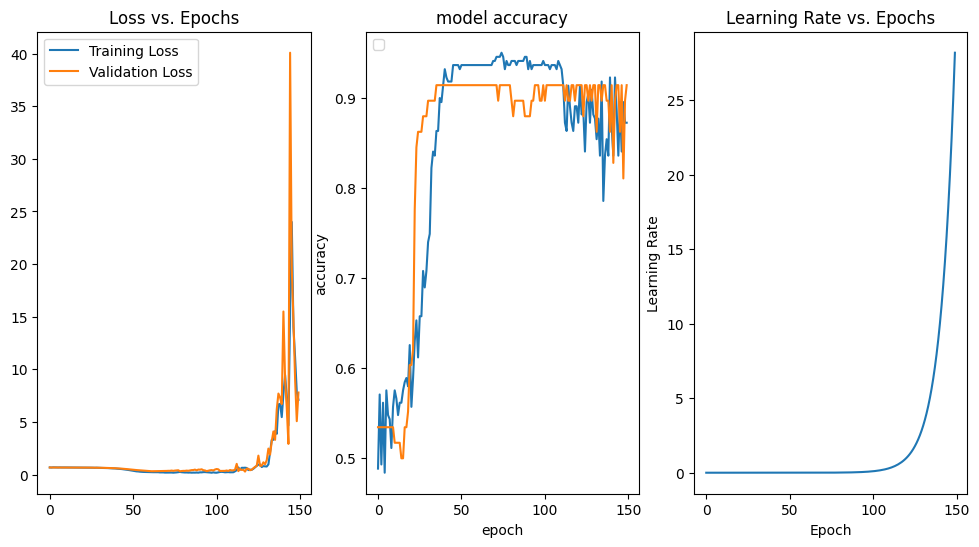

In [20]:
fig, (ax0, ax1,ax2) = plt.subplots(1, 3, figsize=(12, 6))
ax0 = plot_loss(hist1,ax0)
ax1 = plot_accuracy(hist1,ax1)
ax2 = plot_learning_rate(hist1,ax2)

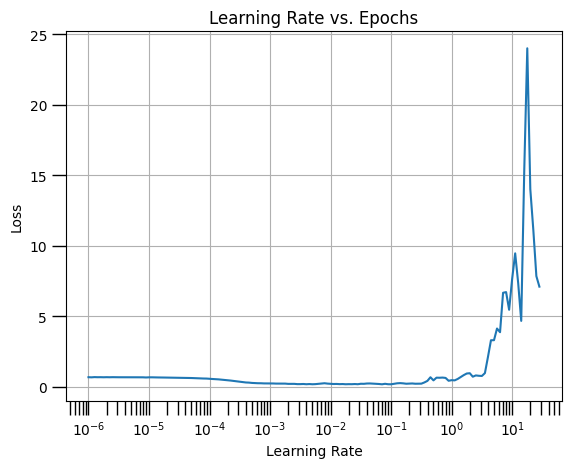

In [21]:
def plot_learning_rate_vs_loss(hist,  lr):
    
    plt.title('Learning Rate vs. Epochs')
    plt.ylabel('Loss')
    plt.xlabel('Learning Rate')
    
    # Define the learning rate array
    lrs = lr * (10 ** (np.arange(epochs) / 20))

    
    # Set the grid
    plt.grid(True)

    # Plot the loss in log scale
    plt.semilogx(lrs, hist.history["loss"] )

    # Increase the tickmarks size
    plt.tick_params('both', length=10, width=1, which='both')
        
        
plot_learning_rate_vs_loss(hist1, 1e-6)
    


### Define Model with a new learning Rate

In [22]:
lr = 1e-4
# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
hist2 = model.fit(train_dataset, epochs=epochs, validation_data=test_dataset)

Epoch 1/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step - accuracy: 0.9105 - loss: 5.7157 - val_accuracy: 0.9138 - val_loss: 7.7994
Epoch 2/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9104 - loss: 5.2640 - val_accuracy: 0.9138 - val_loss: 7.7991
Epoch 3/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9204 - loss: 4.7501 - val_accuracy: 0.9138 - val_loss: 7.7988
Epoch 4/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9198 - loss: 5.9452 - val_accuracy: 0.9138 - val_loss: 7.7982
Epoch 5/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9162 - loss: 6.0966 - val_accuracy: 0.9138 - val_loss: 7.7978
Epoch 6/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9160 - loss: 7.3503 - val_accuracy: 0.9138 - val_loss: 7.7969
Epoch 7/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9134 - loss: 6.4183 - val_accuracy: 0.9138 - val_loss: 7.7964
Epoch 8/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9300 - loss: 5.9997 - val_accuracy: 0.9138 - val_loss: 7.796

2024-10-02 01:42:06.373388: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9116 - loss: 7.7324 - val_accuracy: 0.9138 - val_loss: 7.7619
Epoch 110/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9198 - loss: 6.6119 - val_accuracy: 0.9138 - val_loss: 7.7616
Epoch 111/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9215 - loss: 5.7927 - val_accuracy: 0.9138 - val_loss: 7.7613
Epoch 112/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9156 - loss: 5.9101 - val_accuracy: 0.9138 - val_loss: 7.7609
Epoch 113/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9083 - loss: 6.2126 - val_accuracy: 0.9138 - val_loss: 7.7607
Epoch 114/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9126 - loss: 6.3143 - val_accuracy: 0.9138 - val_loss: 7.7604
Epoch 115/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9215 - loss: 5.2362 - val_accuracy: 0.9138 - val_loss: 7.7602
Epoch 116/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9204 - loss: 5.4314 - val_accuracy: 0.9138 - val_loss: 7.7

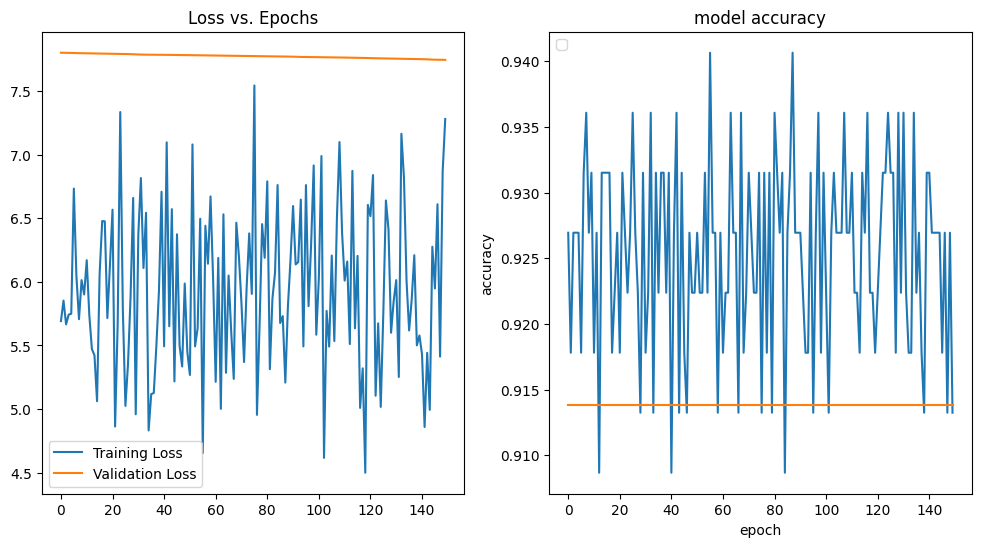

In [23]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(12, 6))
ax0 = plot_loss(hist2,ax0)
ax1 = plot_accuracy(hist2,ax1)

In [24]:
predictions = model.predict(test_dataset)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


              precision    recall  f1-score   support

         0.0       0.91      1.00      0.95        53
         1.0       0.00      0.00      0.00         5

    accuracy                           0.91        58
   macro avg       0.46      0.50      0.48        58
weighted avg       0.84      0.91      0.87        58



/opt/anaconda3/envs/dlLibraries/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/dlLibraries/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/dlLibraries/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is",

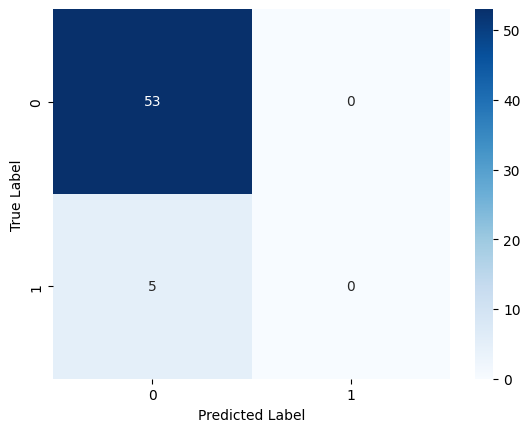

In [25]:
# Convert the predictions to binary
predictions = (predictions > 0.5).astype(int)

# Get the true labels
true_labels = np.array([label for _, label in test_dataset.unbatch()])

# Print the classification report
print(classification_report(true_labels, predictions))

plot_confusion_matrix(predictions, true_labels)


#### Define a CNN model and train the model

In [26]:
modelCNN = Sequential([
    tf.keras.layers.Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(window_size, data.shape[1] - 1)),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

histCNN = model.fit(train_dataset, epochs=epochs, validation_data=test_dataset, callbacks=[lr_schedule])


Epoch 1/150


/opt/anaconda3/envs/dlLibraries/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


      1/Unknown 2s 2s/step - accuracy: 0.8750 - loss: 7.9182

/opt/anaconda3/envs/dlLibraries/lib/python3.12/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step - accuracy: 0.9264 - loss: 5.9218 - val_accuracy: 0.9138 - val_loss: 7.7434 - learning_rate: 1.0000e-06
Epoch 2/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9100 - loss: 5.6451 - val_accuracy: 0.9138 - val_loss: 7.7434 - learning_rate: 1.1220e-06
Epoch 3/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9040 - loss: 6.3144 - val_accuracy: 0.9138 - val_loss: 7.7434 - learning_rate: 1.2589e-06
Epoch 4/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9241 - loss: 5.9929 - val_accuracy: 0.9138 - val_loss: 7.7434 - learning_rate: 1.4125e-06
Epoch 5/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9116 - loss: 4.6169 - val_accuracy: 0.9138 - val_loss: 7.7434 - learning_rate: 1.5849e-06
Epoch 6/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9054 - loss: 7.7570 - val_accuracy: 0.9138 - val_loss: 7.7434 - learning_rate: 1.7783e-06
Epoch 7/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9262 - loss: 4.6246 - val_accu

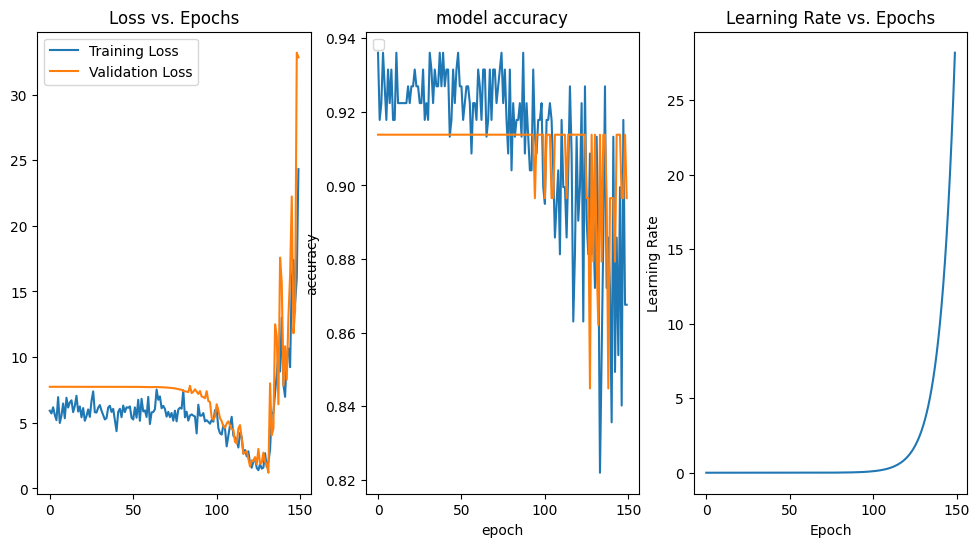

In [27]:
# Plot the training history
fig, (ax0, ax1, ax2) = plt.subplots(1,3, figsize=(12, 6))
ax0 = plot_loss(histCNN,ax0)
ax1 = plot_accuracy(histCNN,ax1)
ax2 = plot_learning_rate(histCNN,ax2)


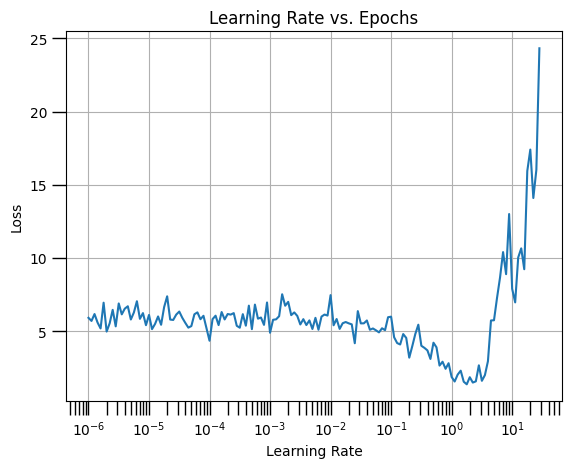

In [28]:
plot_learning_rate_vs_loss(histCNN, 1e-6)

#### Tune the CNN model with new lr

In [29]:
lr = 1e-1
# Compile the model
modelCNN.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr), loss='binary_crossentropy', metrics=['accuracy'])

histCNN = model.fit(train_dataset, epochs=epochs, validation_data=test_dataset)

Epoch 1/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8564 - loss: 26.6119 - val_accuracy: 0.9138 - val_loss: 46.7468
Epoch 2/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8703 - loss: 35.9318 - val_accuracy: 0.9138 - val_loss: 31.9913
Epoch 3/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8759 - loss: 22.5119 - val_accuracy: 0.9138 - val_loss: 24.1464
Epoch 4/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8655 - loss: 23.7790 - val_accuracy: 0.9138 - val_loss: 50.6627
Epoch 5/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9206 - loss: 48.2022 - val_accuracy: 0.9138 - val_loss: 97.2498
Epoch 6/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8613 - loss: 66.6300 - val_accuracy: 0.8793 - val_loss: 16.0692
Epoch 7/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7883 - loss: 42.0760 - val_accuracy: 0.8103 - val_loss: 29.9844
Epoch 8/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8783 - loss: 25.7884 - val_accuracy: 0.8448 - v

2024-10-02 01:42:26.591253: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7669 - loss: 14.1379 - val_accuracy: 0.9138 - val_loss: 37.4851
Epoch 64/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9093 - loss: 29.6780 - val_accuracy: 0.9138 - val_loss: 27.6871
Epoch 65/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8685 - loss: 18.1416 - val_accuracy: 0.9138 - val_loss: 16.2749
Epoch 66/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9001 - loss: 13.6416 - val_accuracy: 0.9138 - val_loss: 26.4159
Epoch 67/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8816 - loss: 26.3301 - val_accuracy: 0.8966 - val_loss: 17.0863
Epoch 68/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8904 - loss: 11.7143 - val_accuracy: 0.8621 - val_loss: 14.7651
Epoch 69/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8145 - loss: 19.4153 - val_accuracy: 0.9138 - val_loss: 28.4742
Epoch 70/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8708 - loss: 15.7883 - val_accuracy: 0.9138 -

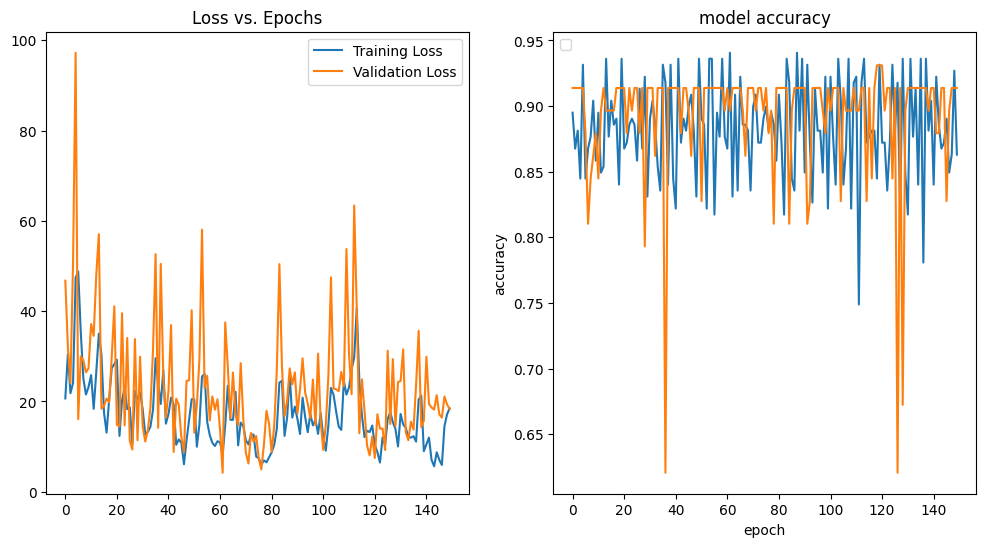

In [30]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(12, 6))
ax0 = plot_loss(histCNN,ax0)
ax1 = plot_accuracy(histCNN,ax1)

#### Evaluate the model

In [31]:
predictionsCNN = modelCNN.predict(test_dataset)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


              precision    recall  f1-score   support

         0.0       0.91      1.00      0.95        53
         1.0       0.00      0.00      0.00         5

    accuracy                           0.91        58
   macro avg       0.46      0.50      0.48        58
weighted avg       0.84      0.91      0.87        58



/opt/anaconda3/envs/dlLibraries/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/dlLibraries/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/dlLibraries/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is",

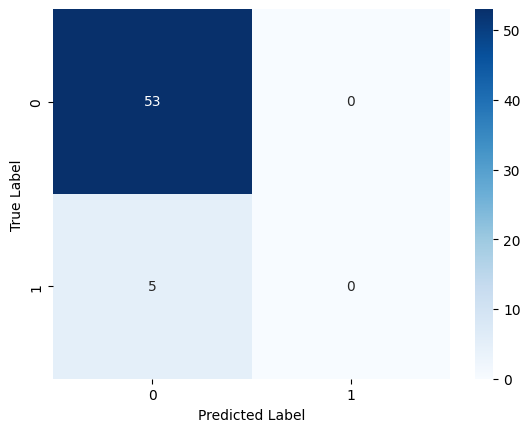

In [32]:
y_predCNN = (predictionsCNN < 0.5).astype(int)
y_trueCNN = np.array([label for _, label in test_dataset.unbatch()])

print(classification_report(y_trueCNN, y_predCNN))

plot_confusion_matrix(y_predCNN, y_trueCNN)

#### Resampling the dataset to make it balanced

In [33]:
### Resmaple the data to balance the classes

# Get the number of samples for each class
class_0 = grouped_df[grouped_df.label_first == 0]

class_1 = grouped_df[grouped_df.label_first == 1]

# Resample the data
class_0_resampled = class_0.sample(len(class_1), replace=True)
resampled_df = pd.concat([class_0_resampled, class_1], axis=0)

# Split the data into features and labels
data_resampled = resampled_df.values

train_dataset_resampled, test_dataset_resampled = split_dataset(0.8, data_resampled, window_size, batch_size, shuffle_buffer)



<Axes: xlabel='label_first', ylabel='count'>

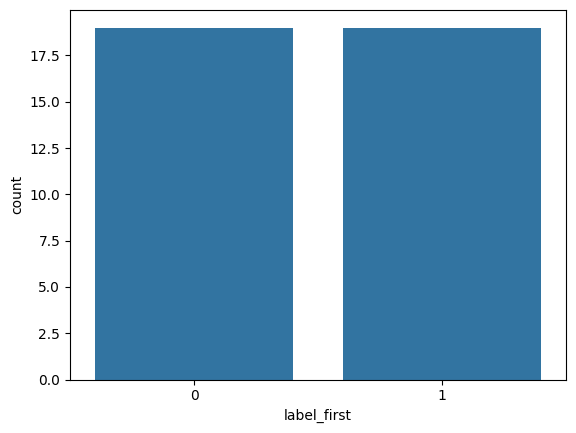

In [34]:
sns.countplot(data=resampled_df, x='label_first')

In [35]:
model_resampled = Sequential([
    # Define an improved LSTM model for classification
    Input(shape=(window_size, data.shape[1] - 1)),
    Bidirectional(LSTM(50, return_sequences=True)),
    Dropout(0.2),
    Bidirectional(LSTM(20)),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

model_resampled.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-6), loss='binary_crossentropy', metrics=['accuracy'])

hist_resampled = model_resampled.fit(train_dataset_resampled, epochs=epochs, validation_data=test_dataset_resampled, callbacks=[lr_schedule])   

Epoch 1/150
      1/Unknown 2s 2s/step - accuracy: 0.2308 - loss: 0.8908

/opt/anaconda3/envs/dlLibraries/lib/python3.12/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.2308 - loss: 0.8908 - val_accuracy: 1.0000 - val_loss: 0.4070 - learning_rate: 1.0000e-06
Epoch 2/150
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.2308 - loss: 0.9078 - val_accuracy: 1.0000 - val_loss: 0.4072 - learning_rate: 1.1220e-06
Epoch 3/150
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.2308 - loss: 0.9947 - val_accuracy: 1.0000 - val_loss: 0.4073 - learning_rate: 1.2589e-06
Epoch 4/150
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.2308 - loss: 0.9764 - val_accuracy: 1.0000 - val_loss: 0.4075 - learning_rate: 1.4125e-06
Epoch 5/150
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.2308 - loss: 0.9273 - val_accuracy: 1.0000 - val_loss: 0.4076 - learning_rate: 1.5849e-06
Epoch 6/150
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.2308 - loss: 0.9054 - val_accuracy: 1.0000 - val_loss: 0.4078 - learning_rate: 1.7783e-06
Epoch 7/150
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.2308 - loss: 0.9350 - val_

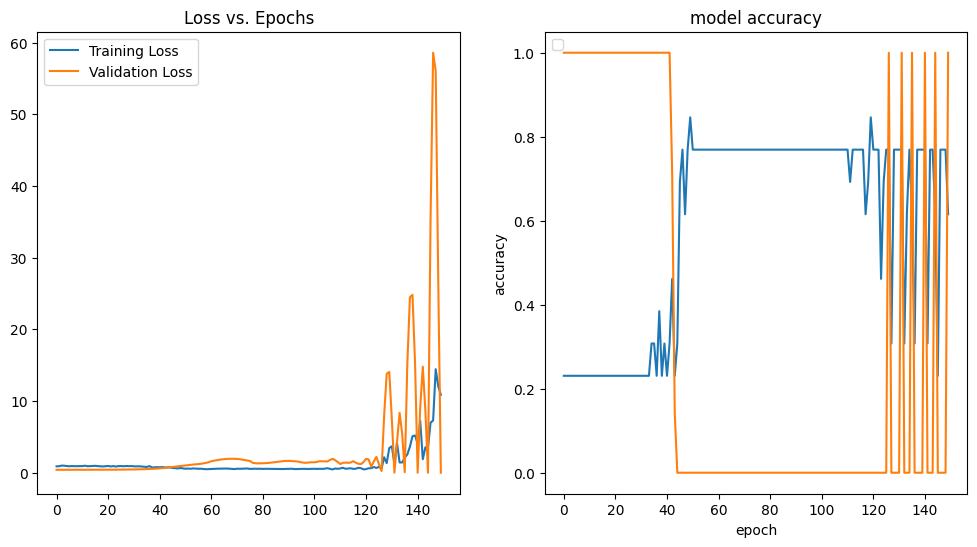

In [36]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(12, 6))

ax0 = plot_loss(hist_resampled,ax0)
ax1 = plot_accuracy(hist_resampled,ax1)

#### Evaluate the model

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00       0.0
         1.0       0.00      0.00      0.00       7.0

    accuracy                           0.00       7.0
   macro avg       0.00      0.00      0.00       7.0
weighted avg       0.00      0.00      0.00       7.0



/opt/anaconda3/envs/dlLibraries/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/dlLibraries/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/dlLibraries/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(res

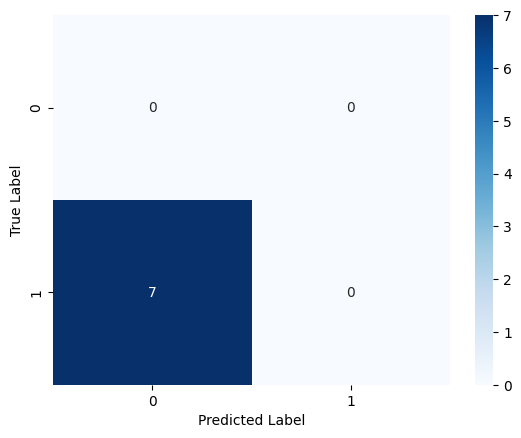

In [37]:
predictions_resampled = model_resampled.predict(test_dataset_resampled)

y_pred_resampled = (predictions_resampled < 0.5).astype(int)
y_true_resampled = np.array([label for _, label in test_dataset_resampled.unbatch()])

print(classification_report(y_true_resampled, y_pred_resampled))

plot_confusion_matrix(y_pred_resampled, y_true_resampled)